# Airbnb Capstone


Airbnb has significantly changed the nature of the short-term property rental market. Not only it has allowed homeowners to earn extra revenue by listing their properties but also provided travelers with great, easy, and convenient places to stay.  

Running Airbnb requires lots of investment, it seems simple on the surface, but it is very involved and complicated in today’s demanding hospitality market. With this in mind, I was still encouraged by the idea of making money from my home when I am not living in it. So in January 2022, I started renting out my two-bedroom condo near Santa Monica Pier. So far, the revenue does not look good and the occupancy rate is below average. Now that I have had a taste of being an Airbnb host for more than a year,  I decided to use data science to analyze the data of the city of Los Angeles which is one of the most active cities in Airbnb markets with more than 21,000 listings by end of 2022.  The goal of the project is to answer the questions below:

1. How are the listings distributed across the city of Los Angeles?
2. How do the prices vary with respect to the neighborhood, property type, and month/day?
3. How to use machine learning models to predict prices using features such as room type, the number of accommodations, the number of bedrooms, and so forth.



# 1. Data Wrangling

###  Import Packages


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gzip
import datetime as dt
import numpy as np

### Load Listings Data Set
The datasets for this project was obtained from 
[Inside Airbnb](http://insideairbnb.com/get-the-data/). I am interested in listings and calendar data for Los Angeles city.


In [65]:
# only load the listing in "City of Los Angeles"

listings = pd.read_csv('listings.csv.gz', compression='gzip',error_bad_lines=False)
listings=listings[listings.neighbourhood_group_cleansed=="City of Los Angeles"]


C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





In [66]:
print(listings.shape)
print(listings.info())

#Check for duplicate listing id
dup= listings.duplicated(subset="id")
print("Dupplicated ID listing",listings[dup==True].count().max())


(21003, 75)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21003 entries, 1 to 40435
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            21003 non-null  int64  
 1   listing_url                                   21003 non-null  object 
 2   scrape_id                                     21003 non-null  int64  
 3   last_scraped                                  21003 non-null  object 
 4   source                                        21003 non-null  object 
 5   name                                          21003 non-null  object 
 6   description                                   20669 non-null  object 
 7   neighborhood_overview                         12693 non-null  object 
 8   picture_url                                   21003 non-null  object 
 9   host_id                                       210

There are 21,003 listings in the area of Los Angeles and each listing has 75 columns. No duplicated ID listing was found. For the purpose of the problem solving, half of the columns seem like they are unuseful so they will be dropped in the next section. 


### Missing Data


In [67]:
#count number of missing data in all columns and sort them from high to low
missing=pd.concat([listings.isnull().sum(),100*listings.isnull().mean()],axis=1)
missing.columns=["count","%"]
print(missing.sort_values(by="count",ascending=False)[missing["count"]>0])

                             count           %
bathrooms                    21003  100.000000
calendar_updated             21003  100.000000
license                      12300   58.563062
neighborhood_overview         8310   39.565776
neighbourhood                 8309   39.561015
host_about                    8022   38.194544
review_scores_value           6872   32.719135
review_scores_location        6871   32.714374
review_scores_checkin         6870   32.709613
review_scores_accuracy        6866   32.690568
review_scores_communication   6865   32.685807
review_scores_cleanliness     6865   32.685807
reviews_per_month             6723   32.009713
first_review                  6723   32.009713
last_review                   6723   32.009713
review_scores_rating          6723   32.009713
host_response_time            5585   26.591439
host_response_rate            5585   26.591439
host_acceptance_rate          5062   24.101319
host_location                 3313   15.773937
bedrooms     

C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [68]:
drop_list=['bathrooms','calendar_updated','name','id','host_id','listing_url','scrape_id','last_scraped','source','description','neighborhood_overview','picture_url','host_url',
      'host_name', 'host_since','host_location','host_about','property_type','host_neighbourhood','neighbourhood_group_cleansed','neighbourhood','host_verifications','host_thumbnail_url',   'host_picture_url', 'calendar_last_scraped',
          'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','host_has_profile_pic','first_review','last_review','host_listings_count','host_total_listings_count',
          'calculated_host_listings_count','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','number_of_reviews_ltm','number_of_reviews_l30d','number_of_reviews'  ]
listings=listings.drop(columns=drop_list,axis=1)
#print(listings.info())

#### Drop data:
1. Drop "bathrooms" and "calendar_updated" columns as they have no data
2. Missing data shows in other columns as well but will keep them all for now as they might hold valueable information for future data exploration 
2. Drop columns that are not useful for data analysis (see drop_list below) 



### Categorical Features

In [69]:
listings.select_dtypes("object").head(1).T

,1
host_response_time,within a few hours
host_response_rate,75%
host_acceptance_rate,38%
host_is_superhost,t
host_identity_verified,t
neighbourhood_cleansed,Hollywood Hills West
room_type,Private room
bathrooms_text,1 shared bath
amenities,"[""TV with standard cable"", ""Hot water"", ""First..."
price,$46.00


### host_response_rate,  host_acceptance_rate and price

Will remove special characters and convert them all to numeric


In [70]:
# using str replace function to remove special character and convert them to float
listings.price=listings.price.str.replace("$","").str.replace(",","").astype("float")
listings.host_response_rate=listings.host_response_rate.str.replace("%","").astype("float")/100
listings.host_acceptance_rate=listings.host_acceptance_rate.str.replace("%","").astype("float")/100


C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



### bathroom_text


In [71]:
# split bathroom_texst into bathroom quanitty and type
listings['bathroom_qty']=listings.bathrooms_text.str.split(" ",expand=True)[0]
listings['bathroom_type']=listings.bathrooms_text.str.split(" ",expand=True)[1]
# count of bathrom qty
listings.bathroom_qty.value_counts()

1            12641
2             3333
2.5           1747
1.5            855
3              806
3.5            377
4              272
4.5            230
8              133
5.5            130
5              120
6               82
6.5             47
7               42
0               38
11              27
Shared          20
8.5             14
7.5             14
Half-bath       12
9                9
10               8
9.5              6
Private          3
12               3
11.5             2
13               2
10.5             2
12.5             1
13.5             1
25               1
21               1
20               1
15               1
Name: bathroom_qty, dtype: int64

In [72]:
# replace string with number
listings.loc[listings.bathroom_qty=="Shared",'bathroom_qty']=0
listings.loc[listings.bathroom_qty=="Half-bath",'bathroom_qty']=0.5
listings.loc[listings.bathroom_qty=="Private",'bathroom_qty']=0.5
listings.bathroom_qty=listings.bathroom_qty.astype("float")

bathroom_text has been splitted into bathroom qty and type columns and the text qty also corrected with numeric value

### Numeric Features

In [73]:
listings.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
host_response_rate,15418.0,0.952549,0.158097,0.00000,0.99000,1.00000,1.000000,1.00000
host_acceptance_rate,15941.0,0.865848,0.236391,0.00000,0.85000,0.98000,1.000000,1.00000
latitude,21003.0,34.081064,0.074501,33.70549,34.04202,34.08047,34.122420,34.32590
longitude,21003.0,-118.375972,0.093773,-118.66307,-118.45154,-118.36742,-118.305905,-118.15579
accommodates,21003.0,3.823597,2.718514,0.00000,2.00000,3.00000,5.000000,16.00000
bedrooms,18760.0,1.777665,1.227769,1.00000,1.00000,1.00000,2.000000,24.00000
beds,20550.0,2.113090,1.575692,1.00000,1.00000,2.00000,3.000000,32.00000
price,21003.0,264.465491,626.354250,0.00000,86.00000,133.00000,231.000000,22092.00000
minimum_nights,21003.0,25.785840,26.437341,1.00000,30.00000,30.00000,30.000000,1124.00000
maximum_nights,21003.0,600.679950,461.926561,1.00000,120.00000,365.00000,1125.000000,3000.00000


### Distrubution of numeric features

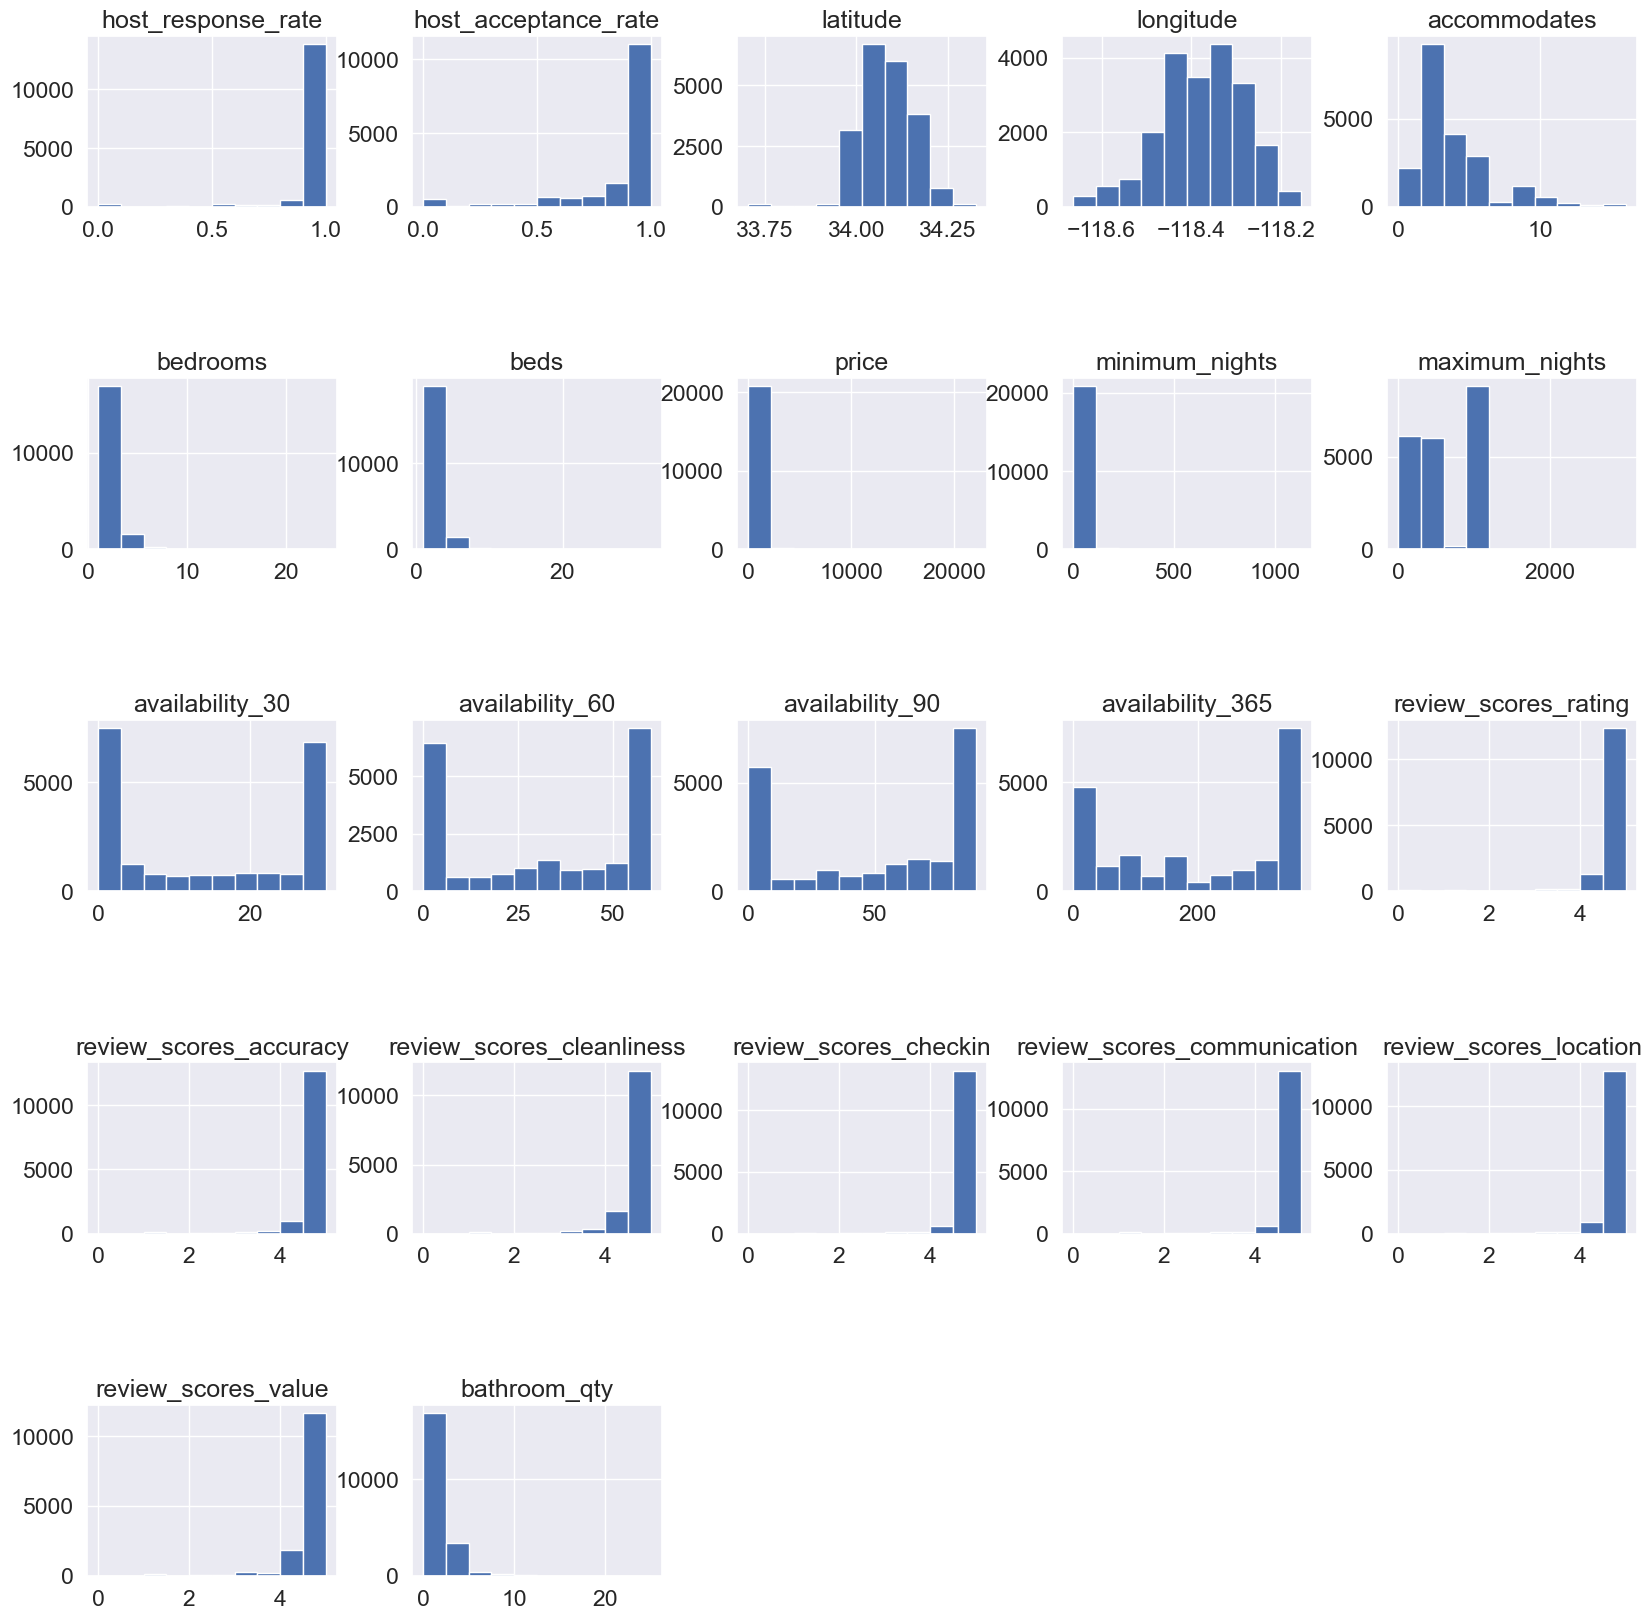

In [74]:
listings.hist(figsize=(20,20))
plt.subplots_adjust(hspace=1);

Observations:
1. Price has long tail and zero values. The high price could be true if the listing is a big house in an expensive neighbourhood. Zero price is not correct and need to be removed.
2. Bedrooms and beds have long tail but this could be true if the listing is an entire big house



### Price


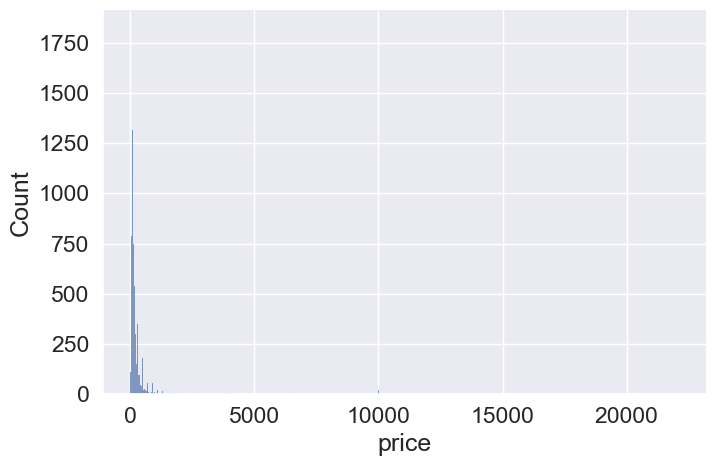

In [75]:
#print(listings.price.describe())
sns.set_theme(font_scale=1.5, style="darkgrid")
sns.displot(data=listings, x="price", kind="hist", aspect=1.5)

The price is skewed with couple significantly high price. Is it possible to have price more than 10,000 a night? Let's reveiw the room_type and neighbourhoud of these listings.



In [76]:
# find the listing with price >10000. are they special listings?
listings[listings.price>10000][["price","room_type","accommodates","bathrooms_text","beds","neighbourhood_cleansed","room_type"]]

,price,room_type,accommodates,bathrooms_text,beds,neighbourhood_cleansed,room_type
7912,21053.0,Entire home/apt,16,12.5 baths,10.0,Bel-Air,Entire home/apt
13692,15000.0,Entire home/apt,16,13 baths,11.0,Bel-Air,Entire home/apt
27063,20084.0,Entire home/apt,16,20 baths,10.0,Bel-Air,Entire home/apt
27066,16078.0,Entire home/apt,14,9 baths,7.0,Hollywood Hills West,Entire home/apt
33638,22092.0,Entire home/apt,16,9.5 baths,11.0,Hollywood Hills West,Entire home/apt


In [77]:
# find the listings with price= 0
#listings[listings.price==0][["price","room_type","accommodates","bathrooms_text","beds","neighbourhood_cleansed","room_type"]]
listings[listings.price==0].count()

# drop listing with price=0
listings=listings[listings.price!=0]

# drop listings with price>5000
listings=listings[listings.price<5000]

Observations:

Listings > $10,000 are in Bel-Air and near Hollywood which are the residential neighborhood of movie stars who live in Hollywood. The houses here are mansions in the foothill of Santa Monica Mountains. The real estate here is very expensive. The listing shows the room_type is entire home with more than 10 bed rooms and 10 bathrooms and accommodate more than 15 guests. These listings are the perfect for a big group to celebrate special occasion. The price seems right for the area but will drop them.

There are more than 10 listings with price equal to $0 which should be removed.

### Price with Log Scale


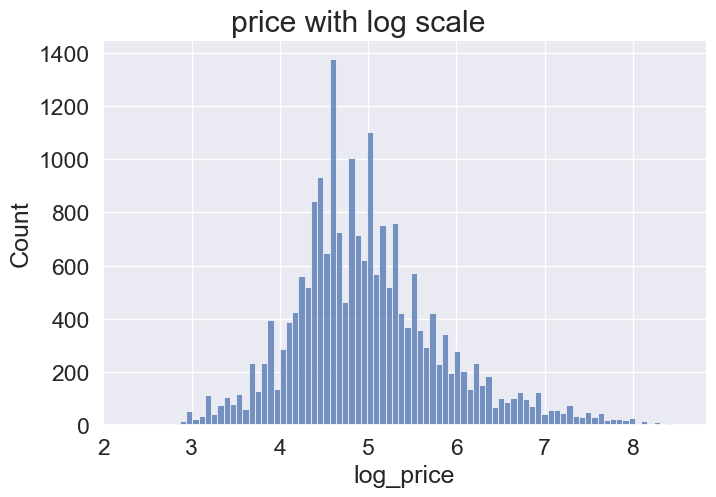

In [78]:
# create a colum for log_price
listings.loc[:,"log_price"]=np.log(listings.loc[:,"price"])

#ax=sns.displot(data=listings,x="price",kind="hist",aspect=1.5)
#ax.fig.suptitle("price with normal scale",y=1.01)
#plt.show()

#listings.loc[:,"log_price"]=np.log(listings.loc[:,"price"])
ax=sns.displot(data=listings,x="log_price",kind="hist",aspect=1.5)
ax.fig.suptitle("price with log scale",y=1.01)
plt.show()

Since the price distribution is not normally distributed, viewing the price in log scale is more visible and interpretablePrice 

## Load Calendar Data Set

In [79]:
calendar = pd.read_csv('calendar.csv.gz', compression='gzip',error_bad_lines=False)
calendar.head(2)

C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,109,2022-12-07,f,$115.00,$115.00,30.0,730.0
1,109,2022-12-08,f,$115.00,$115.00,30.0,730.0


In [80]:
# convert data type of 'date' from object to datetime
calendar['date']=pd.to_datetime(calendar['date'])

# replace '$' and ',' with '' in column 'price'
calendar.price=calendar.price.apply(lambda x: str(x).replace("$","").replace(",",""))

# drop rows with price= 'nan' and convert price from string to numeric
calendar=calendar[calendar.price!='nan']
calendar.price=pd.to_numeric(calendar.price)

# to be consistent with listings data, we will drop listings with price>5000
calendar=calendar[calendar.price<5000]

# Random select 300,000 listings to expedite the execution
#calendar_df=calendar.sample(n=500000,replace=True)
calendar_df=calendar

# transform date column to year, month, and day of week columns  
calendar_df['year']=pd.DatetimeIndex(calendar_df.date).year
calendar_df['month']=calendar_df['date'].dt.strftime('%b')
calendar_df['dayofweek']=calendar_df['date'].dt.day_name()
calendar_df.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,dayofweek
0,109,2022-12-07,f,115.0,$115.00,30.0,730.0,2022,Dec,Wednesday
1,109,2022-12-08,f,115.0,$115.00,30.0,730.0,2022,Dec,Thursday


## Data Wrangling Summary

The original listng data shape was 21003x75. By the end of data wrangling, the data shape is 20993x34. 
41 columns were removed due to no data or un-useful data. The main purpose is to keep the important features at a manageable size that may have a good correlation to the price and location 

Removed special characters in host_response_rate, host_acceptance_rate, price columns and convert them from object to float. Split bathroom_text column into bathoom_qty and bathroom_type columns in the hope to find the correlation between the bathroom_qty with the price. There were couple of listings that did not have the numeric bathroom count so they were replaced with the correct numeric quantity. Also removed listings with price equals to zero or more than $5,000 per ngiht.

For calendar dataset, I converted price column to numeric and split date column into month and day of the week to find the correlation between price and market demand in EDA section

#  2. Exploratory Data Analysis


##  Los Angeles Airbnb Map
Location, location, and location is the key factor in derterming the price for a property so to help me better understand the general geography of Los Angeles, I will start the EDA section by putting all listings on a map to do a little research on the demand.  



In [81]:
import plotly.express as px

color_scale=[(0,'blue'),(0.5,'yellow'),(1,'red')]
fig=px.scatter_mapbox(listings,
                     lat="latitude",
                     lon="longitude",
                     color='price',
                     color_continuous_scale=color_scale,
                     size="price",
                     zoom=10,
                     height=800,
                     width=1000)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Using scatter_map along with features latitude, longiture, and price, I was able to view all Airbnb listings in one beautiful colorful map. Knowing the hilly and flat terrain of the city, I am not surpriced to see most of listings are on the flat area.

The colors blue, yellow, to red is the price range from low to high. You can see there are listing prices as high as five thousands dollar a day. That is insane! These listings mostly reside be on the hill side with fantastic canyon view of the city.




## Listings Count By City

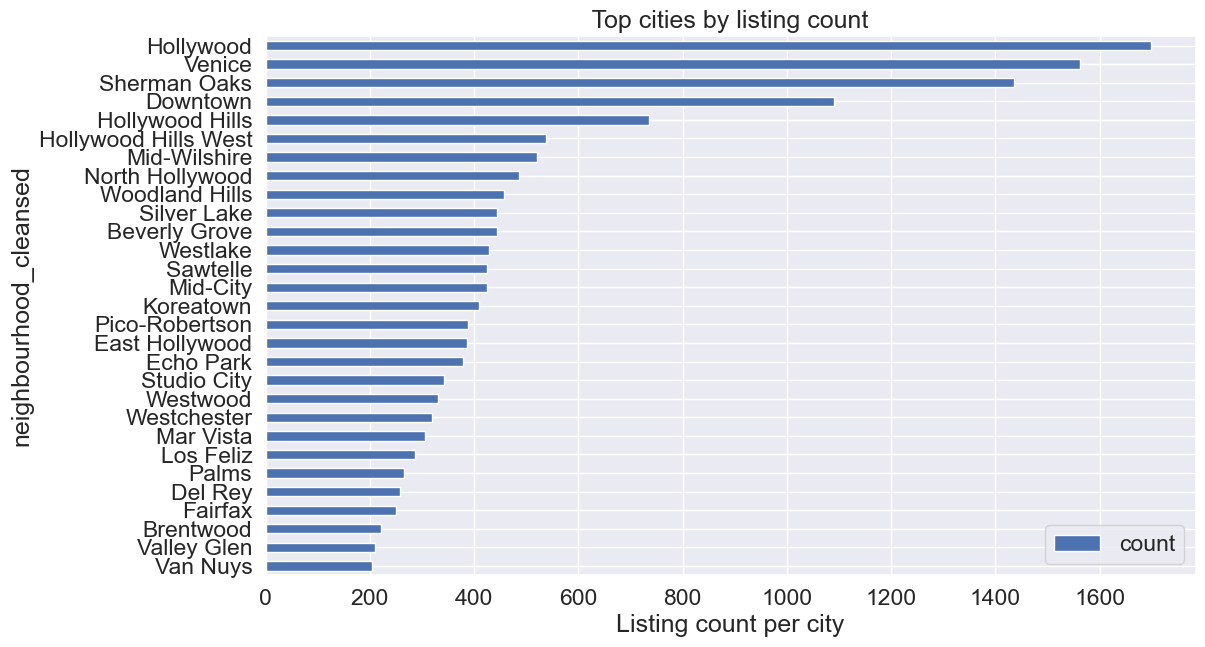

In [82]:
ax=listings.groupby('neighbourhood_cleansed')['price'].agg(['count']).sort_values('count',ascending=True).query('count >200')\
.plot(kind='barh',figsize=(12,7),title=" Top cities by listing count ")
ax.set_xlabel('Listing count per city')
plt.show()

It is a challenge to choose where to stay in Los Angeles since it is one of the largest and most dynamic cities in the US and the main tourist attractions are scattered everywhere. Moreover, the public transportation is not convenient here as it is in New York or San Francisco so almost everyone live in here use car for transportation. Let's dive in to the top three cities and find out why they are popular with Airbnb.

1. Hollywood is the best area to stay in Los Angeles due to it location and security. It is the headquarters of the most famous film studio in the world, Universal Studios and the walk of Fame. Food are also good here

2. Venice is one of the  most popular white sand beaches in Southern California with many thing to do and see like street performers, colorful street art, trendy bars and restaurants. 

3. Sherman Oaks is more affordable, bigger property and not too far from main attractions

## Average Price by City

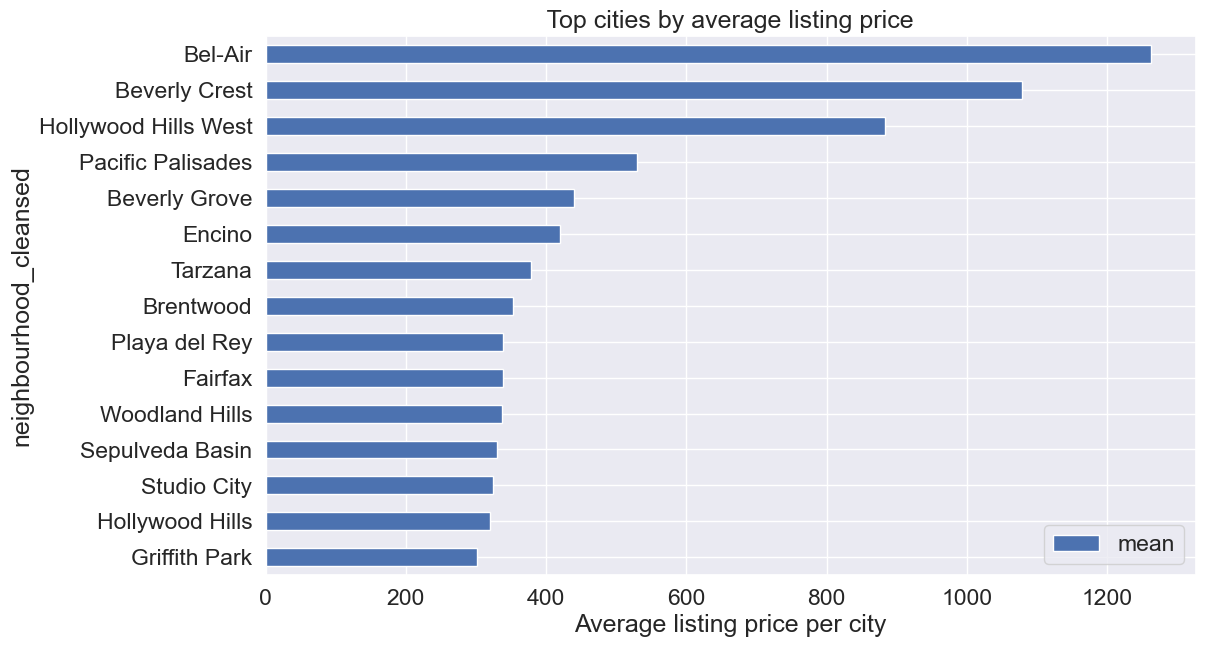

In [83]:
ax=listings.groupby('neighbourhood_cleansed')['price'].agg(['mean']).sort_values('mean',ascending=True).query('mean >300')\
.plot(kind='barh',figsize=(12,7),title=" Top cities by average listing price ")
ax.set_xlabel('Average listing price per city')
plt.show()

Bel-Air. Beverly Crest, and Hollywood Hills West are the most prestigious upscale neighborhoods on the Western part of Los Angeles with very high standard of living. Who can afford renting a property in these area? 

## Room Type

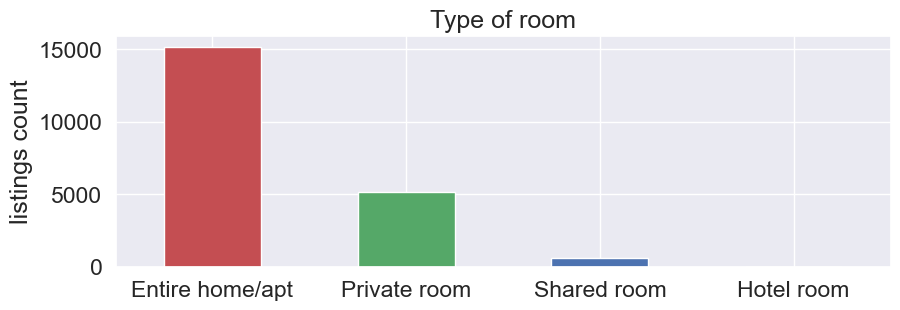

In [84]:
listings.room_type.value_counts().plot.bar(figsize=(10,3), width=0.5,rot=0,color=['r','g','b','y'])
plt.title("Type of room")
plt.ylabel("listings count")
plt.show()

Entire home/apt is the dominant room type which represents 70% of all types of rooms. This is the room type of my property so i should pay more attention during modeling. 

Private room is the second most popular room type. In many expensive and high demand cities such as New York and San Francisco, the research shows it may be possible to pay the entire rent on a two bedroom apartment by filling one of the rooms for 21 days a month. Basically it is rent free for the hosts but keep in mind lots time commitment is involved. 

I am surprised to see the hotel as one of the room types, even though there are not many listings but shows how popular Airbnb is that hotels use it as an additional platform of advertising. 

A side note for first-time homeowners out there, more Airbnb listings mean higher rent and are bad for the housing market. 
 

## Number of guests

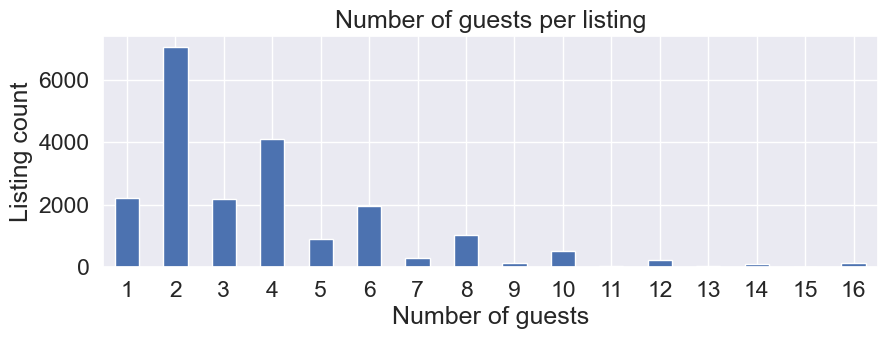

In [85]:
listings.accommodates.value_counts().sort_index().plot.bar(figsize=(10,3), width=0.5,rot=0)
plt.xlabel('Number of guests')
plt.ylabel("Listing count")
plt.title('Number of guests per listing')
plt.show()


The most popular number of guests per listing is two or four. My property also has two bedrooms. There are listings for more than ten guests which is be good for big group. 

## Price vs. month

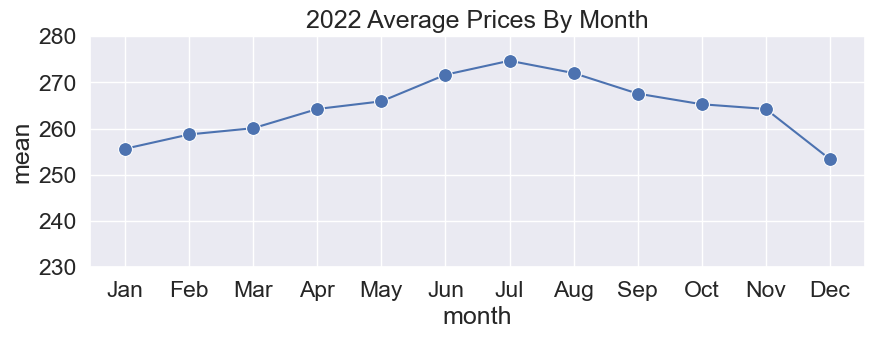

In [86]:
# use groupby to group price by month and order monthe in chronologinal order
month_df=calendar_df.groupby('month')['price'].agg(['mean'])
months_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_df=month_df.reindex(months_order,axis=0)
month_df=month_df.reset_index()

# plot prices vs. month
fig,ax=plt.subplots(figsize=(10,3))
sns.lineplot(x='month',y='mean',data=month_df,marker='o',markersize=10)
ax.set_ylim(230,280)
ax.set_title("2022 Average Prices By Month")
plt.show()

As shown in the plot, it is not a good idea to apply the exact same rate for 365 days a year. Similar to Airbnb, all companies in the travel industry set their prices based on seasonal market demand. Prices are usually soft during school months then peak in the summer months and the holiday season. So it is good to set higher rates for the high season to maximize profit and lower prices for the low season to maximize occupancy. 

Los Angeles is a sunshine city. It has two seasons, dry summer and very mild winter. As a result, there are not many winter activities to do here and I am wondering if that is why the price dipped in December and Janury. 

In contrast with the host, now I know when to travel to save money on hotels. Will save more money in early Spring and Fall. 


## Price vs. day of week

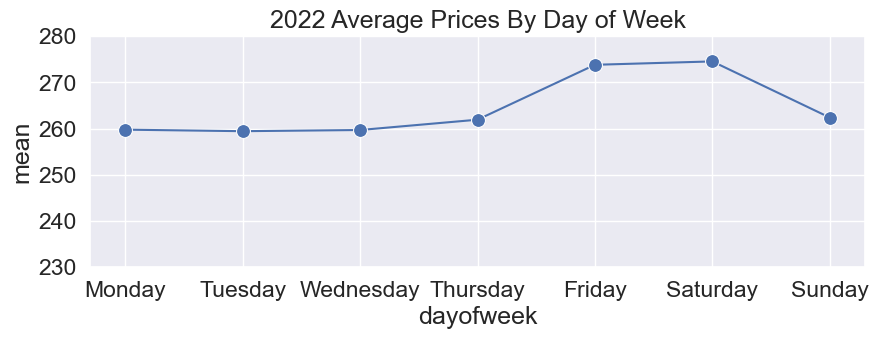

In [87]:
# use groupby to group price by day of week and order them in chronological order from Monday to Sunday
day_df=calendar_df.groupby('dayofweek')['price'].agg(['mean'])
day_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_df=day_df.reindex(day_order).reset_index()


fig,ax=plt.subplots(figsize=(10,3))
sns.lineplot(x='dayofweek',y='mean',data=day_df,marker="o",markersize=10)
ax.set_title("2022 Average Prices By Day of Week")
ax.set_ylim(230,280)
plt.show()

I did the same analysis for the average prices by day of week. The price for Friday and Saturday should be higher. It is understandable as more acitivites happened on these days.  

## Numeric Feature Heatmap

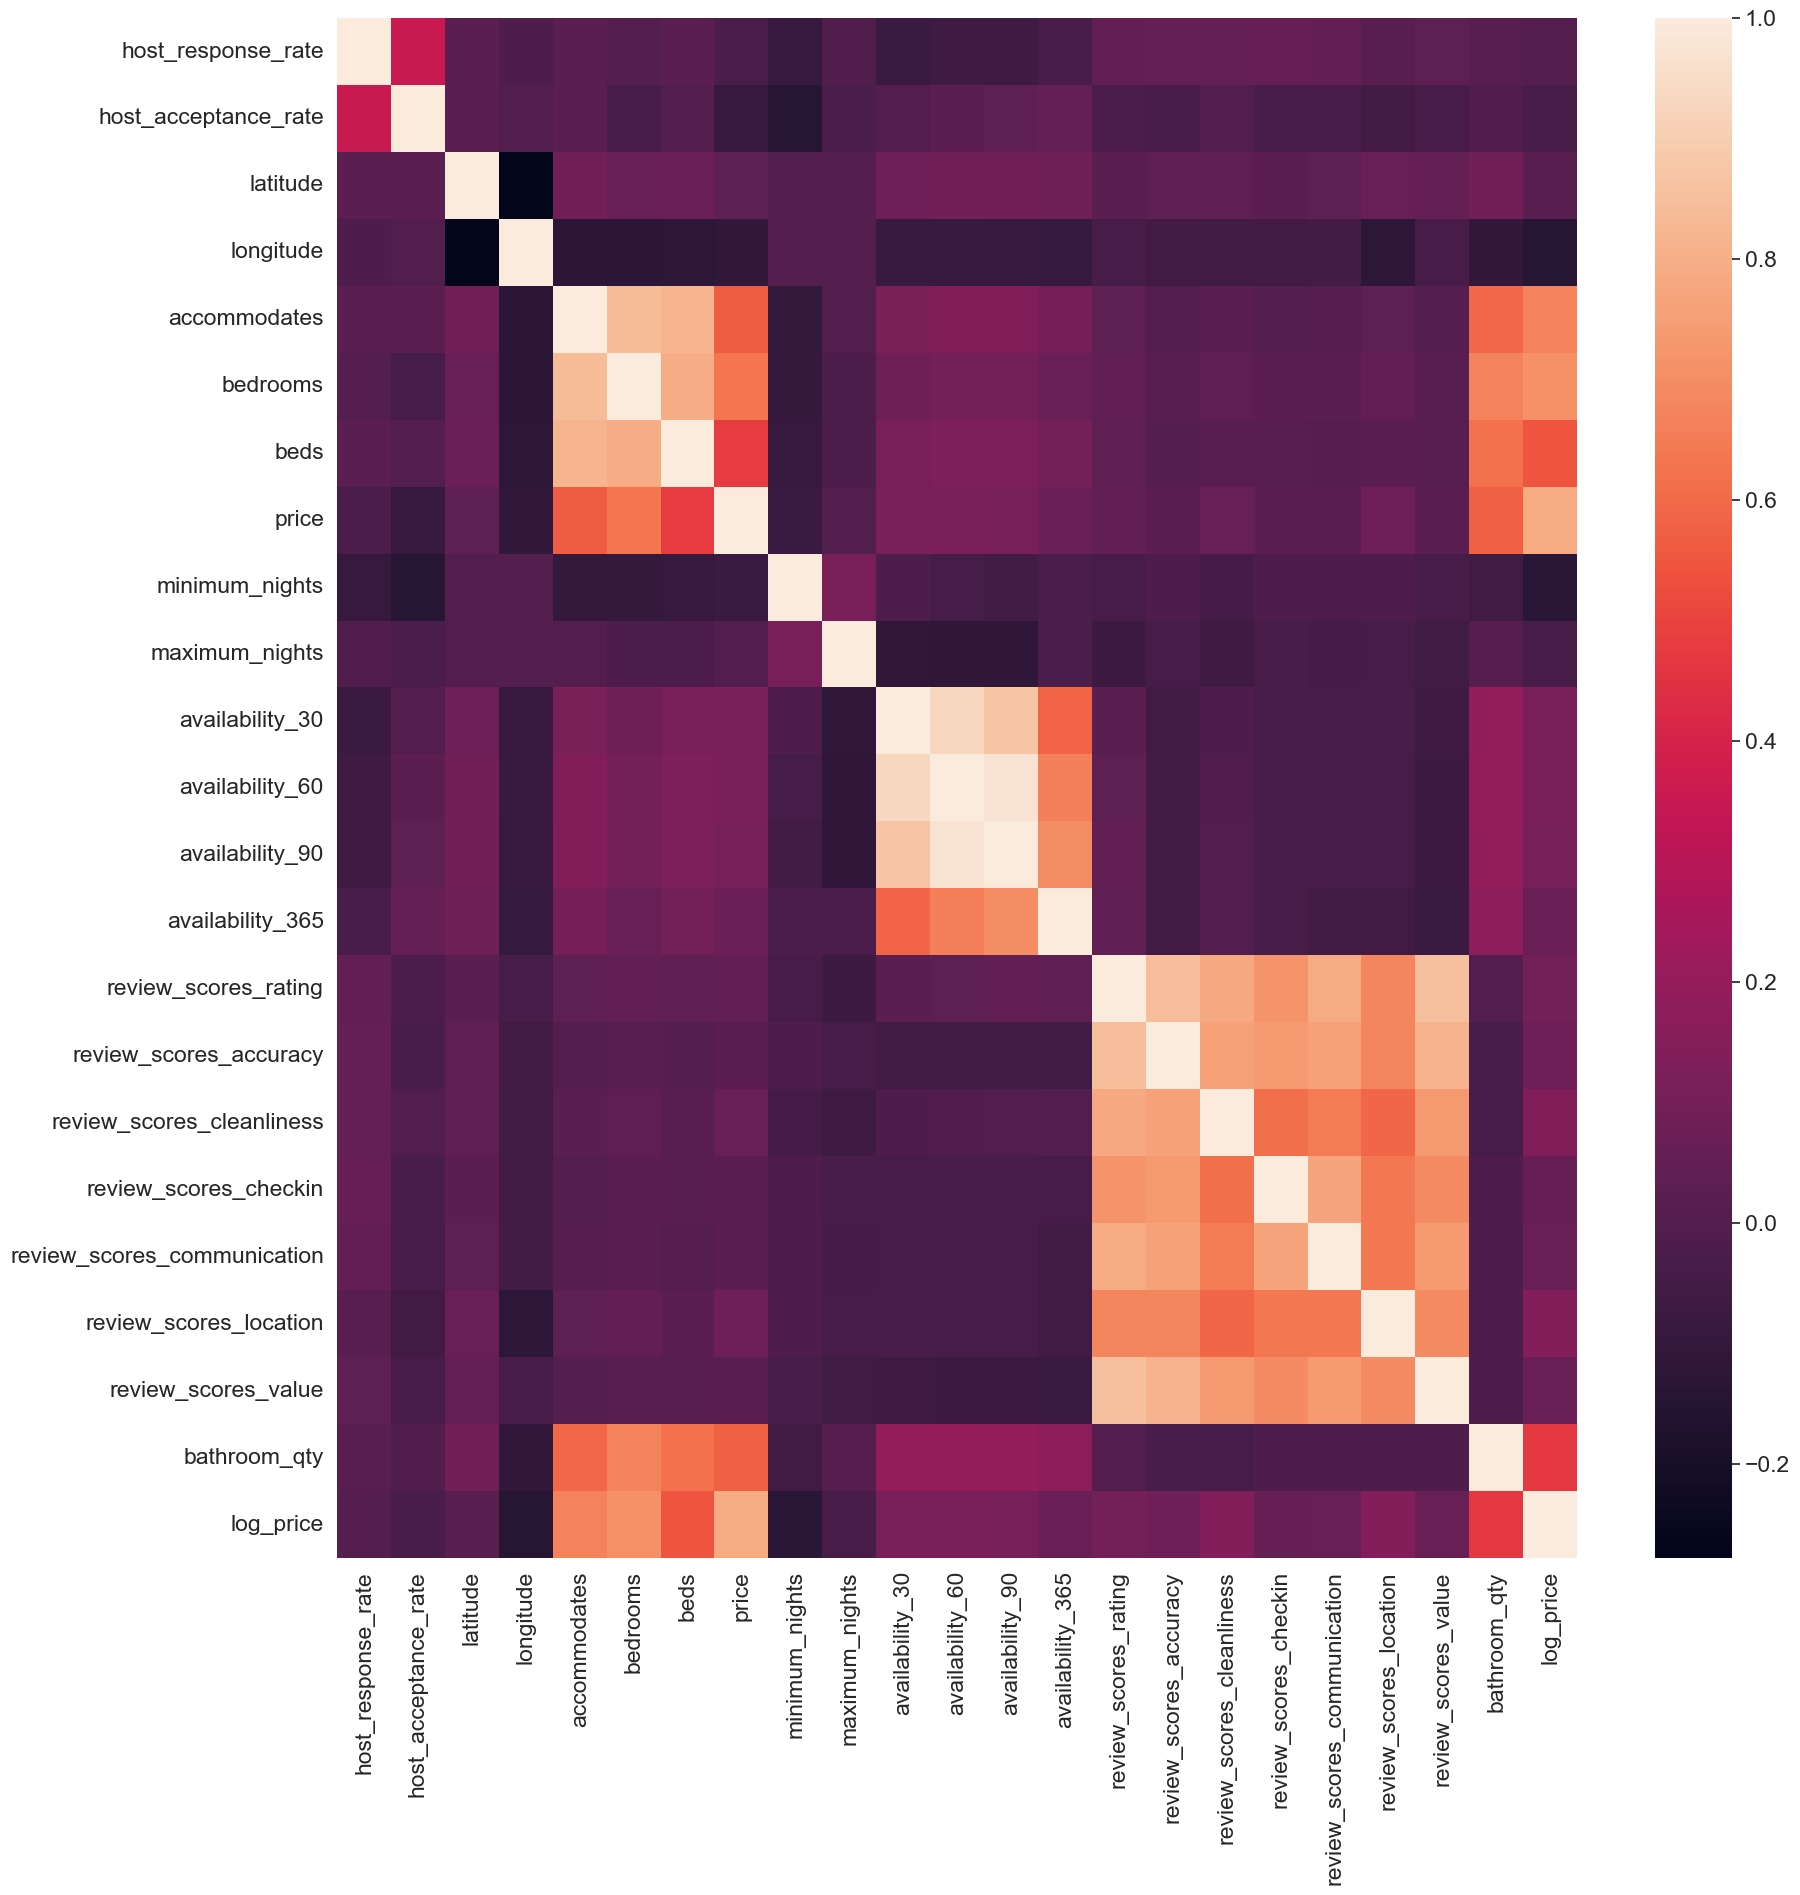

In [88]:
# show  a seaborn heatmap of correlation in airbnb data
plt.subplots(figsize=(20,20))
sns.heatmap(listings.corr());
plt.show()

There is a lot to take from the heatmap. First, as expected accommodates show a strong positive correlation with bedrooms and beds as more people require more rooms and beds. It looks like most of the listings with availability for 30 days are also available for 60 and 90 days but not so much for 365 days. Regarding review scores, do they matter to the guests? Yes, of course! They are the features that guests would look at first when they shop on Airbnb, especially the location and cleanliness. However, the reviews absolutely have no correlation to the price. 

So what features are important to the pricing strategy? Let’s turn our attention back to accommodates, bedrooms, beds, and bathroom_qty. These are the only four features that show resonable positive correlation to the price.  Let’s look at the scatter plots.

## Price vs. all numeric features 

In [100]:
#define a function to create scatterplotf of price against numeric feature

def scatterplots ( columns, ncol=None, figsize=(15,15)):
    if ncol is None:
        ncol=len(columns)
    nrow=int(np.ceil(len(columns)/ncol))
    fig,axes=plt.subplots(nrow,ncol,figsize=figsize,squeeze=False)
    fig.subplots_adjust(wspace=0.5,hspace=0.6)
    for i,col in enumerate(columns):
        ax=axes.flatten()[i]
        ax.scatter(x=col,y='price',data=listings,alpha=0.5)
        ax.set(xlabel=col, ylabel='price')
    nsubplots=nrow*ncol
    for empty in range(i*1,nsubplots):
        axes.flatten()[empty].set_visible(False)


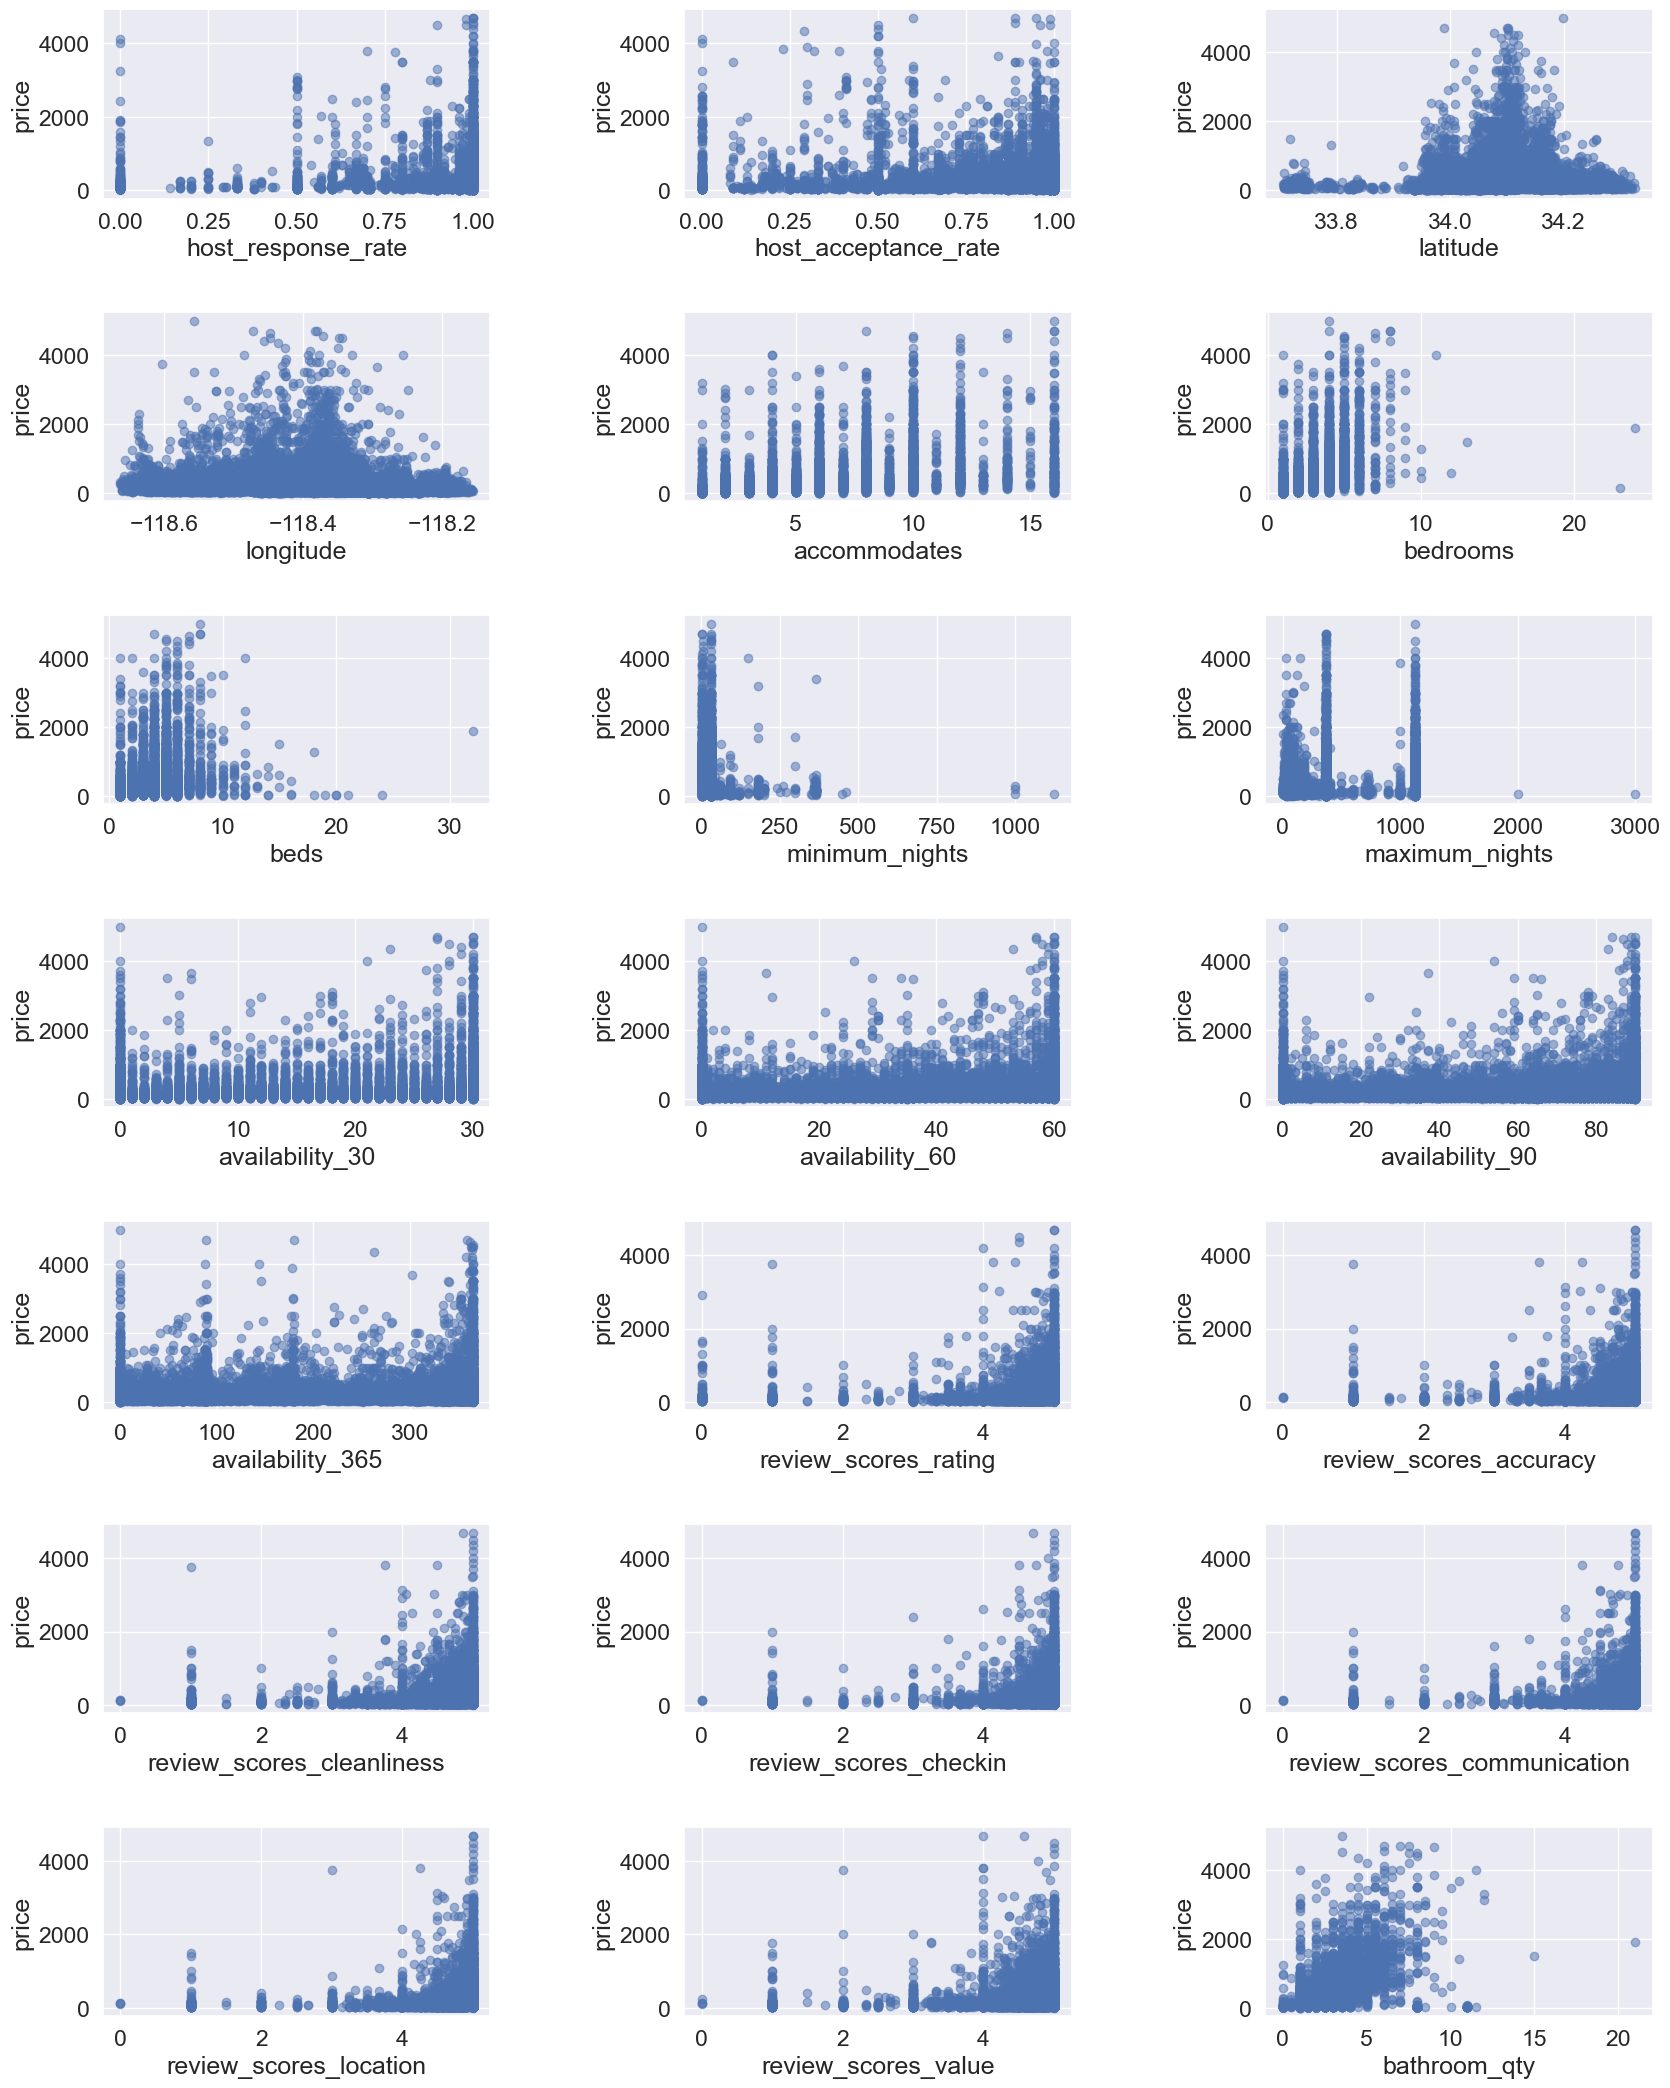

In [101]:
# select numeric features for scatterplots and call scatterplots
features= listings.select_dtypes(include=np.number).columns.tolist()
features.remove("price")
scatterplots(features,ncol=3,figsize=(20,30))

The scatter plots confirm the possitive correlation we saw with the heatmap which are bedrooms, beds and bathroom_qty but not so much on accommodates

## EDA Summary


The best way to understand the data is to demonstrate the data visually. 

It seems intuitively correct that there are patterns suggested of relationships between price and bedrooms, beds, bathroom_qty and accommodates which in fact have a relationship between themself as bigger houses offer more rooms and accommodate. 


Location is the most important factor when searching for a place on Airbnb. Even though latitude and longitude do not show a correlation with price, I am curious to see if they make difference.   

To be a good host is to be flexible with price. Remember that the prices are soft during school months and then increase in the summer months and holiday seasons. Friday and Saturday also have a higher price. Thus, it is ok to set higher rates for the high season to maximize profit and lower prices for the low season to maximize occupancy.

Moving on to the modeling phase, I would like to use the following features:


* Independent variables: bedrooms, beds, bathroom_qty, accomodate. I will also try with and without latitude and longitude.


* Dependent variable: price ( will also try with log_price)




